In [97]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize
import os
from dotenv import load_dotenv

In [78]:
data = pd.read_csv("historic_demand_2009_2024.csv")
data.head()

,Unnamed: 0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
0,0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,NaN,NaN,NaN,1
1,1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
2,2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
3,3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
4,4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1


In [79]:
data.drop(columns=["Unnamed: 0"], errors='ignore', inplace=True)

In [80]:
data.head()
data.shape

(279264, 23)

In [81]:
data["hour"] = data["settlement_period"] * 0.5
data["settlement_date"] = pd.to_datetime(data["settlement_date"])
data["day_of_week"] = data["settlement_date"].dt.dayofweek
data["month"] = data["settlement_date"].dt.month
data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)

In [98]:
API_KEY = os.getenv("API_KEY")

In [99]:
if "latitude" in data.columns and "longitude" in data.columns:
    def get_weather_data(lat, lon, api_key=API_KEY):
        url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}&units=metric"
        response = requests.get(url).json()
        return response.get("main", {}).get("temp", np.nan), response.get("main", {}).get("humidity", np.nan)
    weather_data = [get_weather_data(lat, lon) for lat, lon in zip(data["latitude"], data["longitude"])]
    data["temperature"], data["humidity"] = zip(*weather_data)
    
    data["temperature"].fillna(data["temperature"].mean(), inplace=True)
    data["humidity"].fillna(data["humidity"].mean(), inplace=True)
else:
    data["temperature"], data["humidity"] = np.nan, np.nan
    
    


In [83]:
features = ["hour", "day_of_week", "month", "is_weekend", "temperature", "humidity"]
optional_features = ["embedded_wind_generation", "embedded_solar_generation", "non_bm_stor",
    "pump_storage_pumping", "ifa_flow", "ifa2_flow", "britned_flow",
    "moyle_flow", "east_west_flow", "nemo_flow", "nsl_flow", "eleclink_flow",
    "scottish_transfer", "viking_flow", "greenlink_flow", "is_holiday"]

In [84]:
features.extend([col for col in optional_features if col in data.columns])
X = data[features]
y = data["england_wales_demand"]

In [85]:
X.fillna(X.mean(), inplace=True)

C:\Users\Shahryar Rza\AppData\Local\Temp\ipykernel_3976\642802493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [87]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


c:\Users\Shahryar Rza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1108: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Shahryar Rza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1113: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Shahryar Rza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1133: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [88]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
}


In [89]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {"MAE": mae, "RMSE": rmse}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}")

Random Forest - MAE: 633.7881080693963, RMSE: 953.8730555469846
XGBoost - MAE: 1107.5189570411112, RMSE: 1496.634714810128


In [90]:
best_model = min(results, key=lambda k: results[k]["RMSE"])
print(f"Best model based on RMSE: {best_model}")


Best model based on RMSE: Random Forest


In [91]:
def balance_grid(allocation):
    return np.sum(np.abs(allocation - y_test[:len(allocation)]))  # Minimize imbalance


In [92]:
def constraint_eq(allocation):
    return np.sum(allocation) - np.sum(y_test[:len(allocation)])


In [93]:
sample_size = min(1000, len(y_test))
initial_allocation = np.full(sample_size, np.mean(y_test[:sample_size]))


In [94]:
bounds = [(0.8 * val, 1.2 * val) for val in y_test[:sample_size]]


In [95]:
result = minimize(balance_grid, initial_allocation, bounds=bounds, constraints={"type": "eq", "fun": constraint_eq})
optimal_allocation = result.x

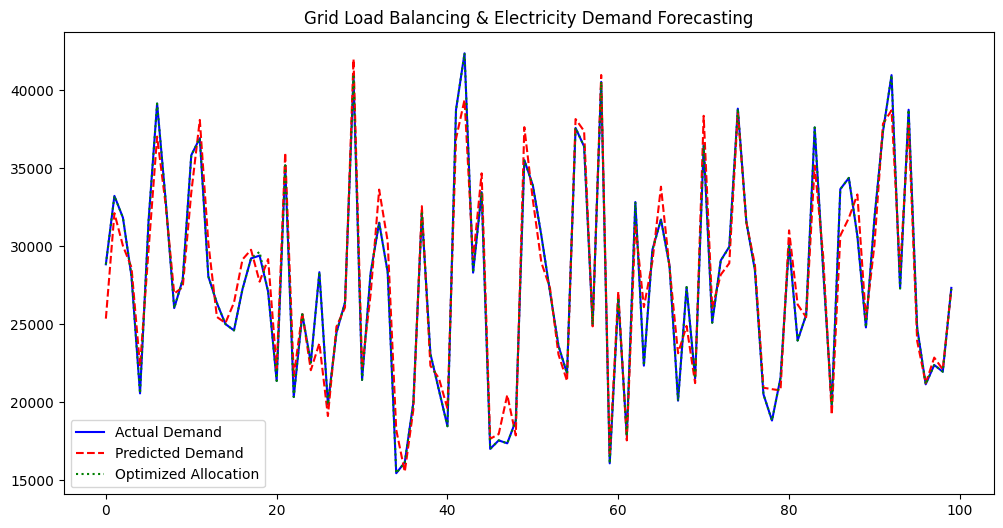

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual Demand', color='blue')
plt.plot(y_pred[:100], label='Predicted Demand', color='red', linestyle='dashed')
plt.plot(optimal_allocation[:100], label='Optimized Allocation', color='green', linestyle='dotted')
plt.legend()
plt.title("Grid Load Balancing & Electricity Demand Forecasting")
plt.show()
